In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# ✅ Base paths
BASE_PATH = "/content/drive/MyDrive/taco_dataset/archive"
DATA_PATH = os.path.join(BASE_PATH, "data")

# Check data folder contents
print("📂 Data folder contains:")
print(os.listdir(DATA_PATH))

# List all batch folders that start with "batch_"
batch_folders = sorted(
    [f for f in os.listdir(DATA_PATH) if f.startswith("batch_")],
    key=lambda x: int(x.split("_")[1])
)

print("\n🗂 Found batch folders:", batch_folders)

# Loop through each batch and count images
for batch in batch_folders:
    batch_path = os.path.join(DATA_PATH, batch)
    img_count = len([f for f in os.listdir(batch_path) if f.lower().endswith(".jpg")])
    print(f"{batch}: {img_count} images")

# Verify the annotation file
ANNOTATIONS_PATH = os.path.join(DATA_PATH, "annotations.json")
print("\n📄 Annotation file exists:", os.path.exists(ANNOTATIONS_PATH))


📂 Data folder contains:
['annotations.json', 'batch_3', 'batch_12', 'batch_2', 'batch_4', 'batch_13', 'batch_14', 'batch_10', 'batch_1', 'batch_15', 'batch_11', 'batch_6', 'batch_5', 'batch_7', 'batch_9', 'batch_8']

🗂 Found batch folders: ['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6', 'batch_7', 'batch_8', 'batch_9', 'batch_10', 'batch_11', 'batch_12', 'batch_13', 'batch_14', 'batch_15']
batch_1: 101 images
batch_2: 92 images
batch_3: 97 images
batch_4: 89 images
batch_5: 112 images
batch_6: 97 images
batch_7: 127 images
batch_8: 100 images
batch_9: 100 images
batch_10: 100 images
batch_11: 100 images
batch_12: 100 images
batch_13: 100 images
batch_14: 100 images
batch_15: 85 images

📄 Annotation file exists: True


In [16]:
import os, json, copy, random, shutil
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

# YOLO
!pip install -q ultralytics
from ultralytics import YOLO

# COCO API
!pip install -q pycocotools
from pycocotools.coco import COCO

In [17]:
# ----------------------------
# 1. PATHS
# ----------------------------
BASE_DATA = '/content/drive/MyDrive/TACO_Dataset/data'
ANNOT_FILE = '/content/drive/MyDrive/taco_dataset/archive/data/annotations.json'
IMG_DIR = '/content/drive/MyDrive/taco_dataset/archive/data'
YOLO_BASE = '/content/drive/MyDrive/TACO_Dataset/yolo_data'
os.makedirs(YOLO_BASE, exist_ok=True)

RESULTS_DIR = '/content/drive/MyDrive/TACO_Dataset/results'
os.makedirs(RESULTS_DIR, exist_ok=True)

In [18]:
# ----------------------------
# 2. LOAD COCO DATA
# ----------------------------
coco = COCO(ANNOT_FILE)
img_ids = coco.getImgIds()
images = coco.loadImgs(img_ids)
ann_ids = coco.getAnnIds()
annotations = coco.loadAnns(ann_ids)
cat_ids = coco.getCatIds()
categories = coco.loadCats(cat_ids)

print(f"Total images: {len(images)}")
print(f"Total annotations: {len(annotations)}")
print(f"Total categories: {len(categories)}")


loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
Total images: 1500
Total annotations: 4784
Total categories: 60


/tmp/ipython-input-2696687782.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top10.values()), y=list(top10.keys()), palette="magma")


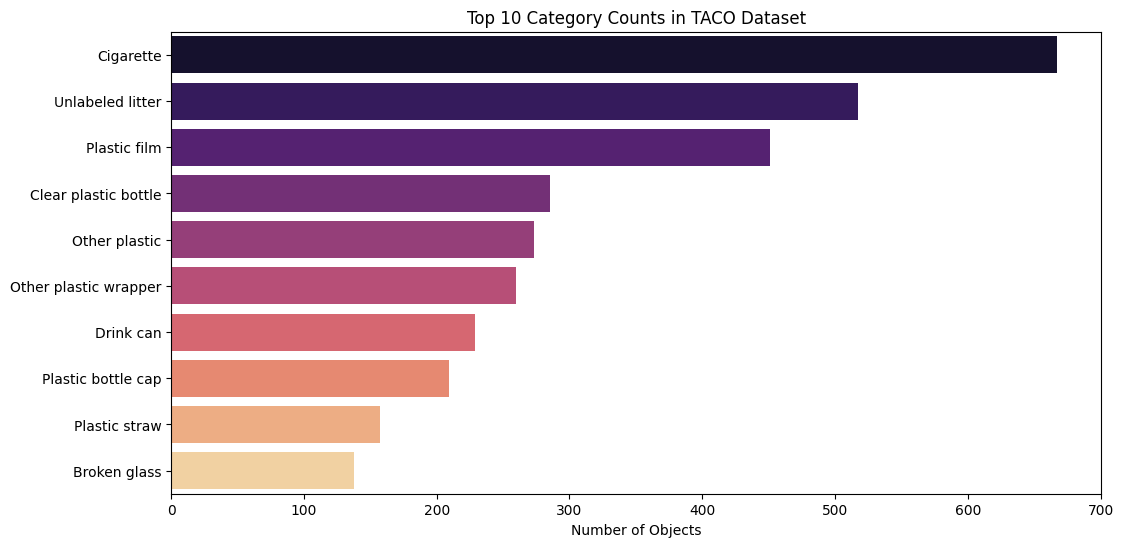

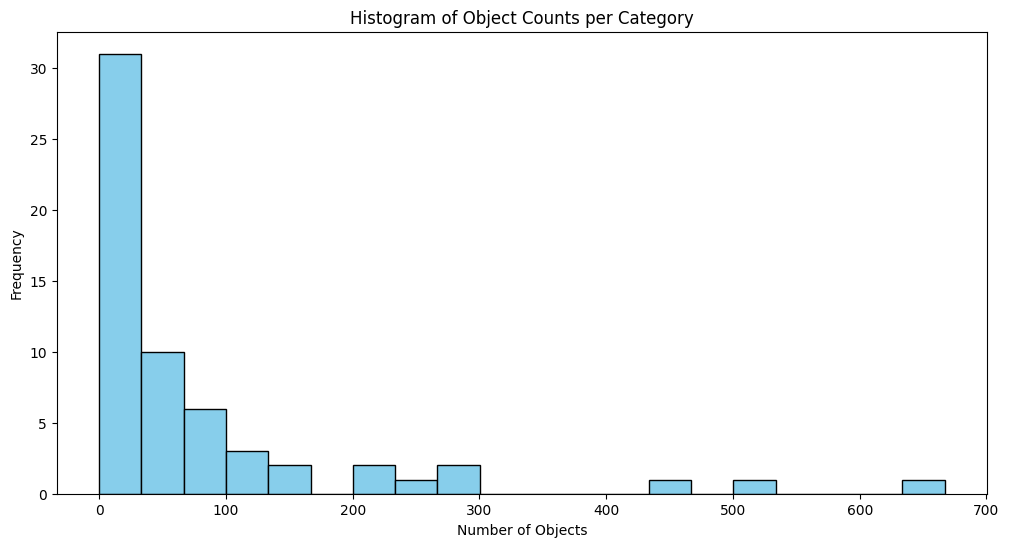

In [ ]:
# ----------------------------
# 3. EDA: CATEGORY DISTRIBUTION
# ----------------------------
cat_counts = {c['name']: len(coco.getAnnIds(catIds=[c['id']])) for c in categories}

# Top 10 barplot
top10 = dict(sorted(cat_counts.items(), key=lambda x:x[1], reverse=True)[:10])
plt.figure(figsize=(12,6))
sns.barplot(x=list(top10.values()), y=list(top10.keys()), palette="magma")
plt.title("Top 10 Category Counts in TACO Dataset")
plt.xlabel("Number of Objects")
plt.savefig(os.path.join(RESULTS_DIR, 'top10_barplot.png'))
plt.show()

# Histogram of counts
plt.figure(figsize=(12,6))
plt.hist(list(cat_counts.values()), bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Object Counts per Category")
plt.xlabel("Number of Objects")
plt.ylabel("Frequency")
plt.savefig(os.path.join(RESULTS_DIR, 'category_histogram.png'))
plt.show()


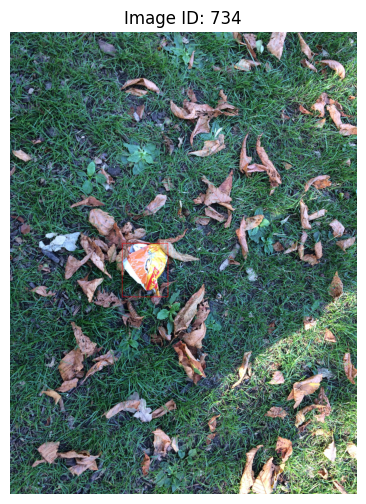

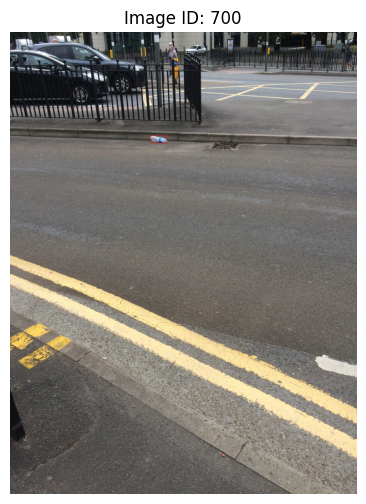

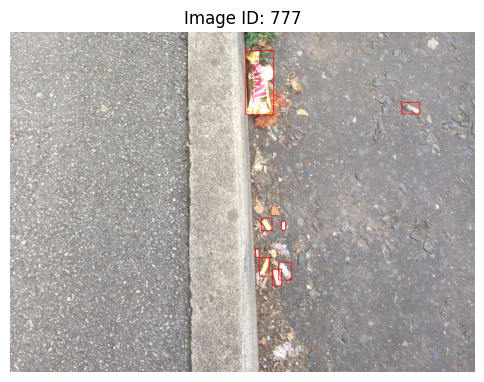

In [ ]:
# ----------------------------
# 4. DISPLAY SAMPLE IMAGES WITH MASKS
# ----------------------------
sample_imgs = random.sample(images, 3)
for img in sample_imgs:
    img_path = os.path.join(IMG_DIR, img['file_name'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    anns_img = coco.loadAnns(coco.getAnnIds(imgIds=[img['id']]))
    for ann in anns_img:
        x,y,w,h = map(int, ann['bbox'])
        cv2.rectangle(image, (x,y), (x+w, y+h), (255,0,0), 2)

    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f"Image ID: {img['id']}")
    plt.axis('off')
    plt.savefig(os.path.join(RESULTS_DIR, f'image_{img["id"]}_masks.png'))
    plt.show()

In [ ]:
# ----------------------------
# 5. SELECT TOP 5 CLASSES + JUSTIFICATION
# ----------------------------
sorted_cats = sorted(cat_counts.items(), key=lambda x:x[1], reverse=True)
top5_names = [name for name,_ in sorted_cats[:5]]
top5_ids = [c['id'] for c in categories if c['name'] in top5_names]
id_map = {orig: new_id for new_id, orig in enumerate(top5_ids)}

subset_anns = []
subset_img_ids = set()
for ann in annotations:
    if ann['category_id'] in top5_ids:
        new_ann = copy.deepcopy(ann)
        new_ann['category_id'] = id_map[ann['category_id']]
        subset_anns.append(new_ann)
        subset_img_ids.add(ann['image_id'])

subset_images = [img for img in images if img['id'] in subset_img_ids]
subset_categories = [{'id': id_map[c['id']], 'name': c['name']}
                     for c in categories if c['id'] in top5_ids]

subset_json_path = os.path.join(YOLO_BASE, "taco_subset.json")
with open(subset_json_path, 'w') as f:
    json.dump({
        'images': subset_images,
        'annotations': subset_anns,
        'categories': subset_categories
    }, f)
print(f"Subset saved: {len(subset_images)} images, {len(subset_anns)} annotations")

Subset saved: 860 images, 2193 annotations


In [ ]:
# --- JUSTIFICATION ---
justification_text = """
Selecting fewer classes (top 5) improves model learning because:
1. Reduces class imbalance and sparsity in training.
2. Focuses the model on categories with sufficient examples.
3. Simplifies the output space, leading to faster convergence and better generalization.
"""
with open(os.path.join(RESULTS_DIR, 'justification.txt'), 'w') as f:
    f.write(justification_text)
print(justification_text)


Selecting fewer classes (top 5) improves model learning because:
1. Reduces class imbalance and sparsity in training.
2. Focuses the model on categories with sufficient examples.
3. Simplifies the output space, leading to faster convergence and better generalization.



In [ ]:
# ----------------------------
# 6. CREATE YOLO DATA STRUCTURE
# ----------------------------
splits = ['train','val','test']
for s in splits:
    os.makedirs(f"{YOLO_BASE}/{s}/images", exist_ok=True)
    os.makedirs(f"{YOLO_BASE}/{s}/labels", exist_ok=True)

img_ids_list = [img['id'] for img in subset_images]
train_ids, test_val_ids = train_test_split(img_ids_list, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(test_val_ids, test_size=0.5, random_state=42)
split_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
print(f"Split sizes -> Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")

def coco2yolo(img_w,img_h,bbox):
    x,y,w,h = bbox
    xc = (x+w/2)/img_w
    yc = (y+h/2)/img_h
    return xc,yc,w/img_w,h/img_h

for split_name, ids in split_dict.items():
    for img_id in tqdm(ids, desc=f"Processing {split_name}"):
        img_info = next(img for img in subset_images if img['id']==img_id)
        filename = img_info['file_name'].replace('/','_')
        src_img_path = os.path.join(IMG_DIR, img_info['file_name'])
        dst_img_path = os.path.join(YOLO_BASE, split_name, 'images', filename)
        shutil.copy(src_img_path, dst_img_path)

        # write labels
        label_path = os.path.join(YOLO_BASE, split_name, 'labels', filename.rsplit('.',1)[0]+'.txt')
        anns_img = [a for a in subset_anns if a['image_id']==img_id]
        with open(label_path,'w') as f:
            for a in anns_img:
                x,y,w,h = coco2yolo(img_info['width'], img_info['height'], a['bbox'])
                f.write(f"{a['category_id']} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")


Split sizes -> Train: 602, Val: 129, Test: 129


Processing train:   0%|          | 0/602 [00:00<?, ?it/s]

Processing val:   0%|          | 0/129 [00:00<?, ?it/s]

Processing test:   0%|          | 0/129 [00:00<?, ?it/s]

In [ ]:
# ----------------------------
# 7. CREATE data.yaml FOR YOLO
# ----------------------------
import yaml
yaml_dict = {
    'path': YOLO_BASE,
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'names': {i:name for i,name in enumerate(top5_names)}
}
yaml_path = os.path.join(YOLO_BASE, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_dict, f)
print("data.yaml created.")


data.yaml created.


In [ ]:
# Zip YOLO dataset to Drive
shutil.make_archive(os.path.join(RESULTS_DIR,'yolo_dataset'), 'zip', YOLO_BASE)
print("YOLO dataset zipped and saved to Drive.")

YOLO dataset zipped and saved to Drive.


In [ ]:
import torch
# ----------------------------
# 8. TRAIN YOLOv8: BASELINE (No Augmentation)
# ----------------------------
model_no_aug = YOLO('yolov8n.yaml')
results_no_aug = model_no_aug.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    name='baseline_no_aug',
    project=RESULTS_DIR,
    device='cuda' if torch.cuda.is_available() else 'cpu',

    # DISABLE AUGMENTATION
    hsv_h=0, hsv_s=0, hsv_v=0,
    degrees=0, translate=0, scale=0, shear=0, perspective=0,
    fliplr=0, flipud=0, mosaic=0, mixup=0, copy_paste=0
)

# Save metrics to CSV
metrics_no_aug = pd.DataFrame(results_no_aug.metrics)
metrics_no_aug.to_csv(os.path.join(RESULTS_DIR,'metrics_baseline_no_aug.csv'), index=False)


Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/TACO_Dataset/yolo_data/data.yaml, degrees=0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0, flipud=0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0, hsv_s=0, hsv_v=0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=0, multi_scale=False, name=baseline_no_aug, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0, plot

AttributeError: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.
Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes,
            target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metrics.
        clear_stats: Clear the stored statistics.
        keys: Return a list of keys for accessing specific metrics.
        mean_results: Calculate mean of detected objects & return precision, recall, mAP50, and mAP50-95.
        class_result: Return the result of evaluating the performance of an object detection model on a specific class.
        maps: Return mean Average Precision (mAP) scores per class.
        fitness: Return the fitness of box object.
        ap_class_index: Return the average precision index per class.
        results_dict: Return dictionary of computed performance metrics and statistics.
        curves: Return a list of curves for accessing specific metrics curves.
        curves_results: Return a list of computed performance metrics and statistics.
        summary: Generate a summarized representation of per-class detection metrics as a list of dictionaries.
    

In [ ]:
# Evaluate on test set
results_no_aug = model_no_aug.val(split='test')

# Access metrics
print(results_no_aug.box)        # Box metrics: precision, recall, mAP50, mAP50-95
print(results_no_aug.box.map50)  # mAP@50
print(results_no_aug.box.map)    # mAP@50-95


Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.3±1.2 ms, read: 140.3±137.4 MB/s, size: 1961.8 KB)
val: Scanning /content/drive/MyDrive/TACO_Dataset/yolo_data/test/labels... 129 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 129/129 86.5it/s 1.5s
val: /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_8_000000.jpg: 1 duplicate labels removed
val: New cache created: /content/drive/MyDrive/TACO_Dataset/yolo_data/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 1.2s/it 10.6s
                   all        129        275      0.127     0.0361     0.0313     0.0159
             Cigarette         32         43      0.452      0.116      0.108     0.0622
      Unlabeled litter         25         28      0.117     0.0357     0.0234    0.00816
      

In [ ]:
# Save to Drive
shutil.make_archive('/content/drive/MyDrive/baseline_no_aug', 'zip', '/content/taco_project/baseline_no_aug')


FileNotFoundError: [Errno 2] No such file or directory: '/content/taco_project/baseline_no_aug'

In [ ]:
import torch
# ----------------------------
# 9. TRAIN YOLOv8: AUGMENTED
# ----------------------------
model_aug = YOLO('yolov8n.yaml')
results_aug = model_aug.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    name='augmented_model',
    project=RESULTS_DIR,
    device='cuda' if torch.cuda.is_available() else 'cpu',

    # ENABLE AUGMENTATIONS
    mosaic=1.0, fliplr=0.5, flipud=0.5,
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    degrees=15, scale=0.5, shear=2, translate=0.1
)

# Save metrics
metrics_aug = pd.DataFrame(results_aug.metrics)
metrics_aug.to_csv(os.path.join(RESULTS_DIR,'metrics_augmented.csv'), index=False)


Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/TACO_Dataset/yolo_data/data.yaml, degrees=15, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=augmented_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

In [ ]:
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import cv2

# ============================
# Correct Paths
# ============================
BASE_DIR = '/content/drive/MyDrive/TACO_Dataset'
YOLO_DIR = f'{BASE_DIR}/yolo_data'
RESULTS_DIR = f'{BASE_DIR}/results'

data_yaml = f'{YOLO_DIR}/data.yaml'

baseline_model_path = f'{RESULTS_DIR}/baseline_no_aug/weights/best.pt'
aug_model_path = f'{RESULTS_DIR}/augmented_model/weights/best.pt'

OUTPUT_DIR = f'{RESULTS_DIR}/comparison_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load models
model_baseline = YOLO(baseline_model_path)
model_aug = YOLO(aug_model_path)


In [ ]:
print("Evaluating baseline model...")
metrics_baseline = model_baseline.val(data=data_yaml, split='test', save=False)

print("Evaluating augmented model...")
metrics_aug = model_aug.val(data=data_yaml, split='test', save=False)


Evaluating baseline model...
Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 4.8±9.8 ms, read: 213.9±175.2 MB/s, size: 1389.3 KB)
val: Scanning /content/drive/MyDrive/TACO_Dataset/yolo_data/test/labels.cache... 129 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 129/129 152.7Kit/s 0.0s
val: /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_8_000000.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 1.1s/it 9.9s
                   all        129        275      0.127     0.0361     0.0313     0.0159
             Cigarette         32         43      0.452      0.116      0.108     0.0622
      Unlabeled litter         25         28      0.117     0.0357     0.0234    0.00816
          Plastic film         53         69     0.0414   

In [ ]:
baseline_results = {
    "Precision": metrics_baseline.results_dict['metrics/precision(B)'],
    "Recall": metrics_baseline.results_dict['metrics/recall(B)'],
    "mAP50": metrics_baseline.results_dict['metrics/mAP50(B)'],
    "mAP50-95": metrics_baseline.results_dict['metrics/mAP50-95(B)']
}

aug_results = {
    "Precision": metrics_aug.results_dict['metrics/precision(B)'],
    "Recall": metrics_aug.results_dict['metrics/recall(B)'],
    "mAP50": metrics_aug.results_dict['metrics/mAP50(B)'],
    "mAP50-95": metrics_aug.results_dict['metrics/mAP50-95(B)']
}

print("\n=== BASELINE METRICS ===")
print(baseline_results)

print("\n=== AUGMENTED METRICS ===")
print(aug_results)



=== BASELINE METRICS ===
{'Precision': 0.12717784764981968, 'Recall': 0.0361141232294339, 'mAP50': 0.031299701697368135, 'mAP50-95': 0.01592378311443536}

=== AUGMENTED METRICS ===
{'Precision': 0.12865985662879934, 'Recall': 0.15676611065109905, 'mAP50': 0.07743491441075159, 'mAP50-95': 0.031060573780751822}


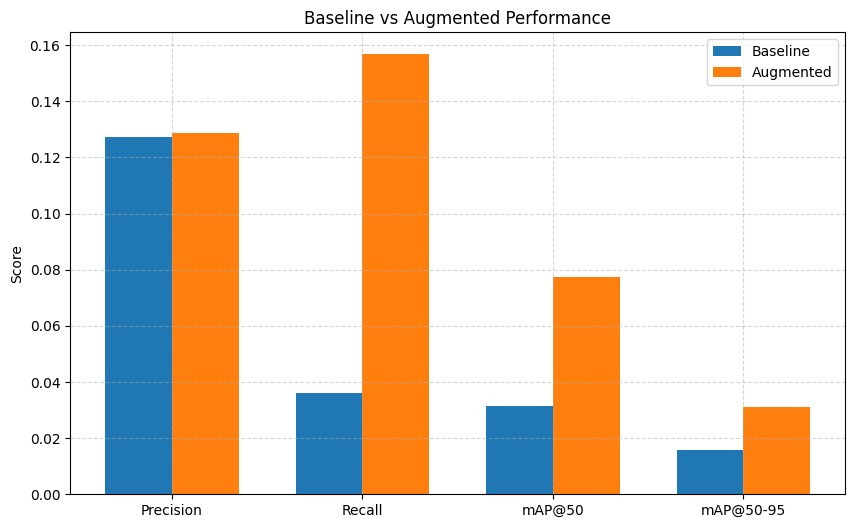

In [ ]:
import numpy as np

labels = ["Precision", "Recall", "mAP@50", "mAP@50-95"]
baseline_vals = list(baseline_results.values())
aug_vals = list(aug_results.values())

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - w/2, baseline_vals, width=w, label='Baseline')
plt.bar(x + w/2, aug_vals, width=w, label='Augmented')

plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Baseline vs Augmented Performance")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.savefig(f"{OUTPUT_DIR}/comparison_plot.png", dpi=300)
plt.show()



image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_15_000003.jpg: 640x480 (no detections), 6.8ms
Speed: 2.9ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_15_000003.jpg: 640x480 1 Cigarette, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


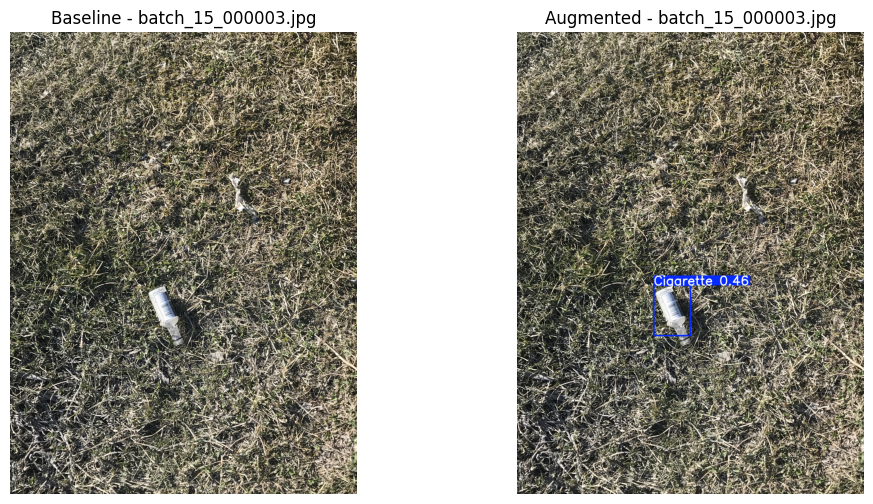


image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_9_000006.jpg: 640x480 (no detections), 8.1ms
Speed: 4.0ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_9_000006.jpg: 640x480 1 Plastic film, 8.1ms
Speed: 4.2ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


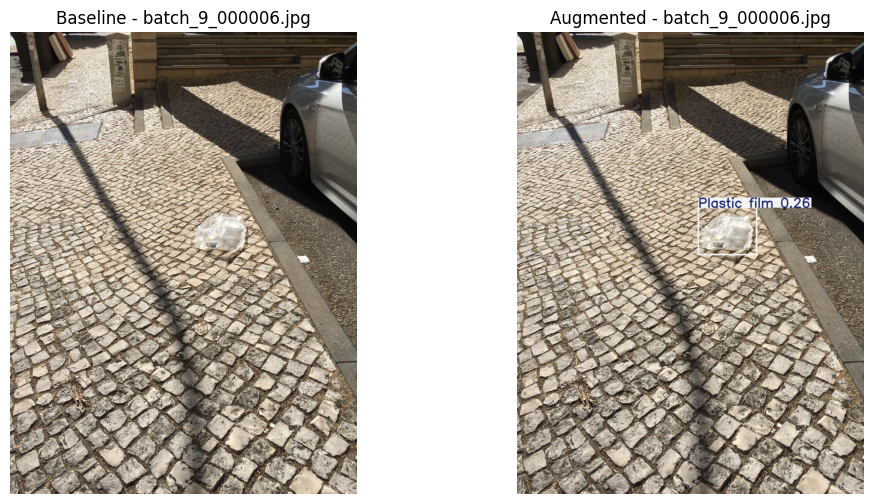


image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_6_000103.JPG: 480x640 (no detections), 13.2ms
Speed: 4.2ms preprocess, 13.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_6_000103.JPG: 480x640 (no detections), 11.2ms
Speed: 3.8ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


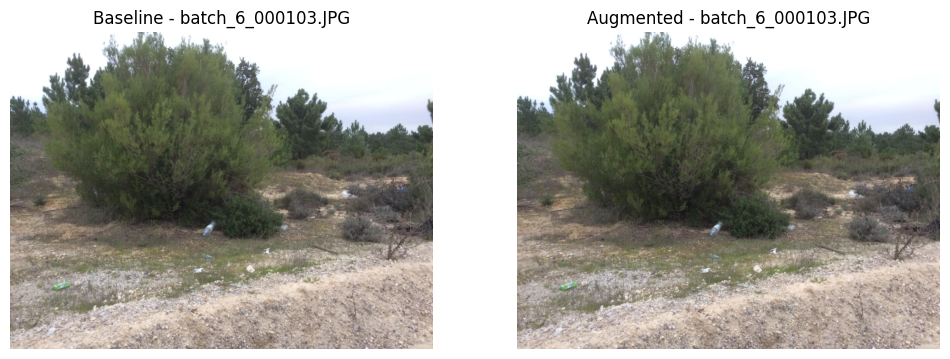


image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_8_000021.jpg: 480x640 (no detections), 7.9ms
Speed: 4.0ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_8_000021.jpg: 480x640 (no detections), 7.5ms
Speed: 4.0ms preprocess, 7.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


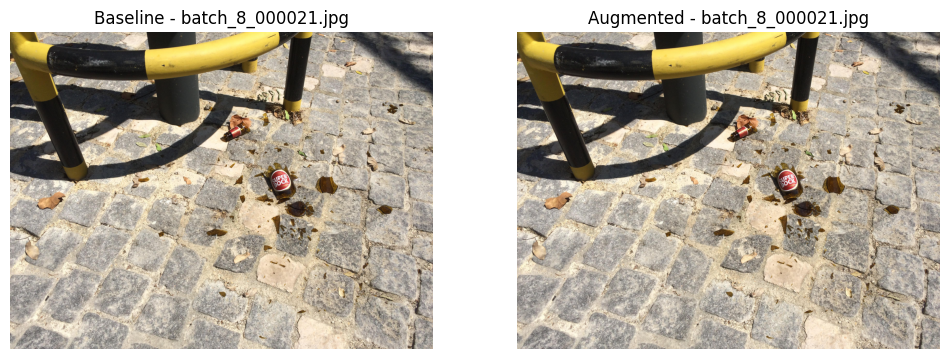


image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_10_000062.jpg: 320x640 (no detections), 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_10_000062.jpg: 320x640 (no detections), 8.4ms
Speed: 3.6ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


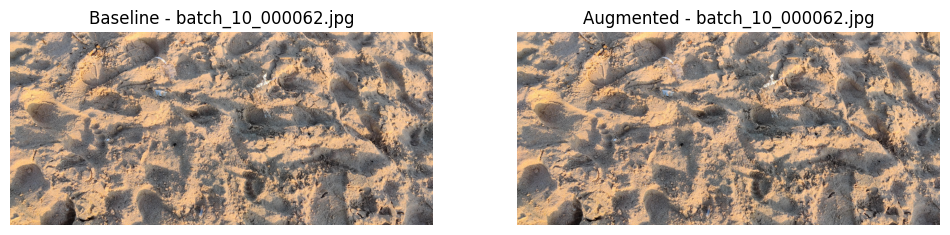

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ----------------------------
# Paths
# ----------------------------
RESULTS_DIR = '/content/drive/MyDrive/TACO_Dataset/results'
BASELINE_DIR = os.path.join(RESULTS_DIR, 'baseline_no_aug', 'weights')
AUG_DIR = os.path.join(RESULTS_DIR, 'augmented_model', 'weights')

# Automatically detect the best.pt file
baseline_weight = os.path.join(BASELINE_DIR, 'best.pt')
aug_weight      = os.path.join(AUG_DIR, 'best.pt')

assert os.path.exists(baseline_weight), f"Baseline weights not found: {baseline_weight}"
assert os.path.exists(aug_weight), f"Augmented weights not found: {aug_weight}"

# Load models
model_baseline = YOLO(baseline_weight)
model_aug      = YOLO(aug_weight)

# ----------------------------
# Select random sample images for inference
# ----------------------------
IMG_DIR = '/content/drive/MyDrive/TACO_Dataset/yolo_data/test/images'  # Update if your test images are elsewhere
sample_images = random.sample(os.listdir(IMG_DIR), 5)  # Pick 5 random images

# ----------------------------
# Run inference and plot results
# ----------------------------
for img_file in sample_images:
    img_path = os.path.join(IMG_DIR, img_file)

    # Baseline prediction
    results_baseline = model_baseline.predict(img_path, conf=0.25, save=False)
    img_b = results_baseline[0].plot()

    # Augmented prediction
    results_aug = model_aug.predict(img_path, conf=0.25, save=False)
    img_a = results_aug[0].plot()

    # Plot side by side
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB))
    plt.title(f"Baseline - {img_file}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB))
    plt.title(f"Augmented - {img_file}")
    plt.axis('off')

    plt.show()


In [9]:
from ultralytics import YOLO

model_no_aug = YOLO("yolov8n.pt")  # pretrained weights

results_no_aug = model_no_aug.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    project=RESULTS_DIR,
    name="baseline_pretrained_v1",   # avoid overwrite
)
#

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/TACO_Dataset/yolo_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_pretrained_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patie

In [11]:
from ultralytics import YOLO

# Load pretrained YOLOv8n (same as baseline)
model_aug = YOLO("yolov8n.pt")

# Train with strong augmentation
results_aug = model_aug.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    project=RESULTS_DIR,
    name="augmented_v1",        # <-- prevents overwrite
    hsv_h=0.015,                 # color hue shift
    hsv_s=0.7,                   # strong saturation shift
    hsv_v=0.4,                   # brightness variation
    degrees=10,                  # rotation
    translate=0.1,               # translation
    scale=0.5,                   # random scaling / zoom
    shear=2.0,                   # shearing
    flipud=0.2,                  # vertical flip
    fliplr=0.5,                  # horizontal flip
    mosaic=1.0,                  # ENABLE strong mosaic augmentation
    mixup=0.2                    # MixUp augmentation
)


Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/TACO_Dataset/yolo_data/data.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.2, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=augmented_v12, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, p

In [21]:
from ultralytics import YOLO
import os
import pandas as pd

# -----------------------
# Load trained weights
# -----------------------
baseline_path = os.path.join(RESULTS_DIR, "baseline_pretrained_v1", "weights", "best.pt")
aug_path      = os.path.join(RESULTS_DIR, "augmented_v12", "weights", "best.pt")

model_baseline = YOLO(baseline_path)
model_aug = YOLO(aug_path)

# -----------------------
# Evaluate both models
# -----------------------
print("Evaluating Baseline (No Aug)…")
metrics_base = model_baseline.val()

print("\nEvaluating Augmented Model…")
metrics_aug = model_aug.val()

# -----------------------
# Extract important numbers
# -----------------------
baseline_data = {
    "Model": "Pretrained No-Aug",
    "mAP50": metrics_base.box.map50,
    "mAP50-95": metrics_base.box.map,
    "Precision": metrics_base.box.mp,
    "Recall": metrics_base.box.mr
}

aug_data = {
    "Model": "Pretrained + Augmentation",
    "mAP50": metrics_aug.box.map50,
    "mAP50-95": metrics_aug.box.map,
    "Precision": metrics_aug.box.mp,
    "Recall": metrics_aug.box.mr
}

# -----------------------
# Build comparison table
# -----------------------
df_compare = pd.DataFrame([baseline_data, aug_data])
print("\n=== MODEL PERFORMANCE COMPARISON ===")
print(df_compare)



Evaluating Baseline (No Aug)…
Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 361.0±101.6 MB/s, size: 2057.0 KB)
val: Scanning /content/drive/MyDrive/TACO_Dataset/yolo_data/val/labels.cache... 129 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 129/129 223.4Kit/s 0.0s
val: /content/drive/MyDrive/TACO_Dataset/yolo_data/val/images/batch_10_000000.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 1.1s/it 9.5s
                   all        129        343      0.264      0.227      0.189      0.121
             Cigarette         34         49      0.486      0.612      0.567      0.371
      Unlabeled litter         25         64      0.183     0.0938     0.0655     0.0484
          Plastic film         50         86      0.334     


image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_7_000016.JPG: 640x480 1 Cigarette, 1 Clear plastic bottle, 40.0ms
Speed: 2.8ms preprocess, 40.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_7_000016.JPG: 640x480 1 Cigarette, 6.7ms
Speed: 2.7ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


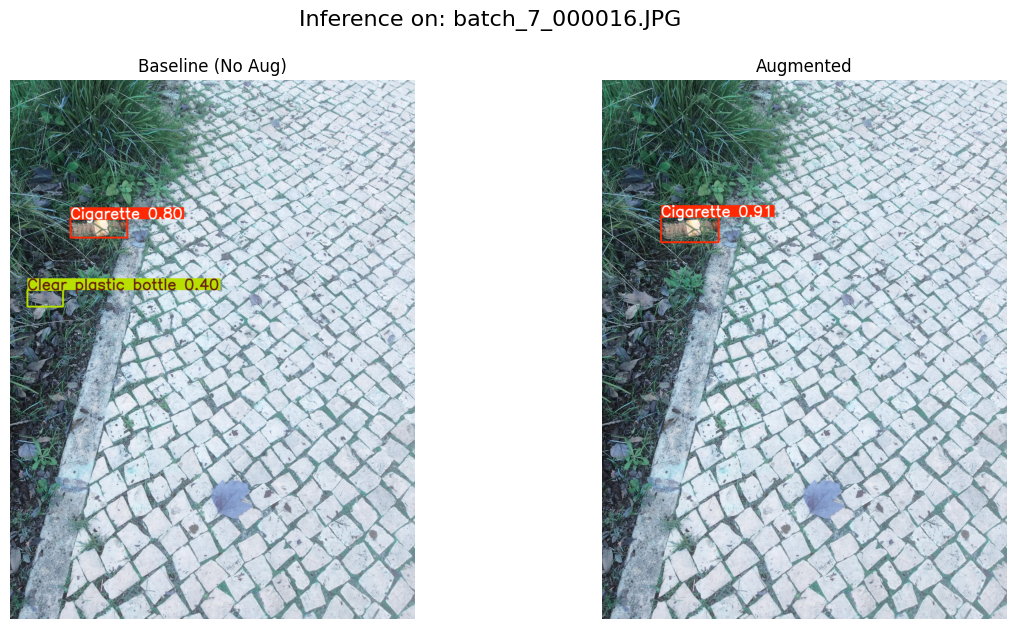


image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_5_000092.JPG: 640x480 (no detections), 14.3ms
Speed: 6.4ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_5_000092.JPG: 640x480 (no detections), 95.7ms
Speed: 9.9ms preprocess, 95.7ms inference, 37.2ms postprocess per image at shape (1, 3, 640, 480)


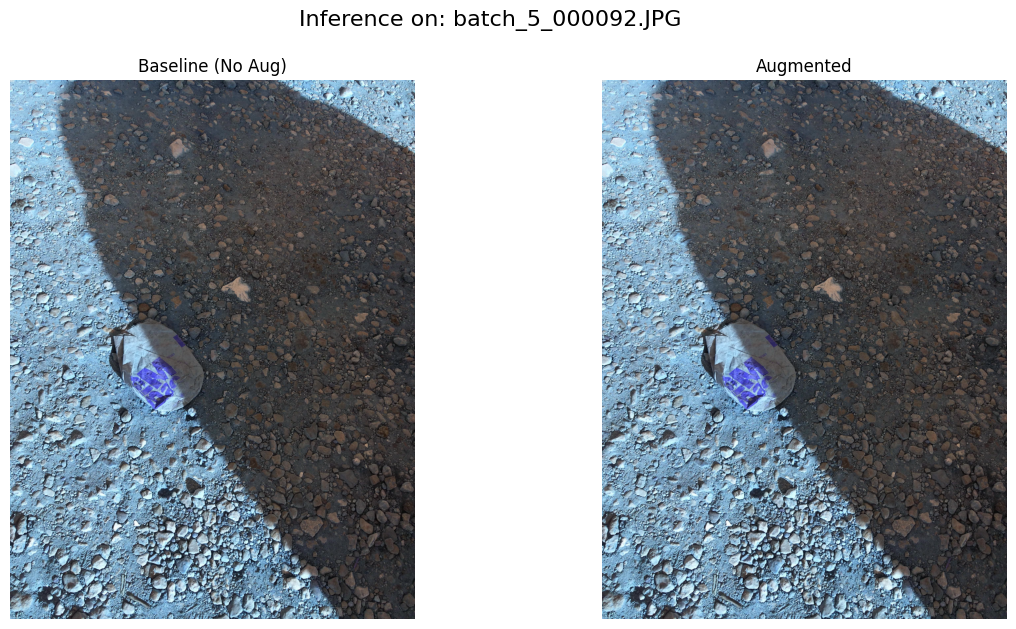


image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_4_000032.JPG: 640x480 2 Cigarettes, 1 Plastic film, 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/drive/MyDrive/TACO_Dataset/yolo_data/test/images/batch_4_000032.JPG: 640x480 2 Cigarettes, 1 Other plastic, 8.3ms
Speed: 4.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


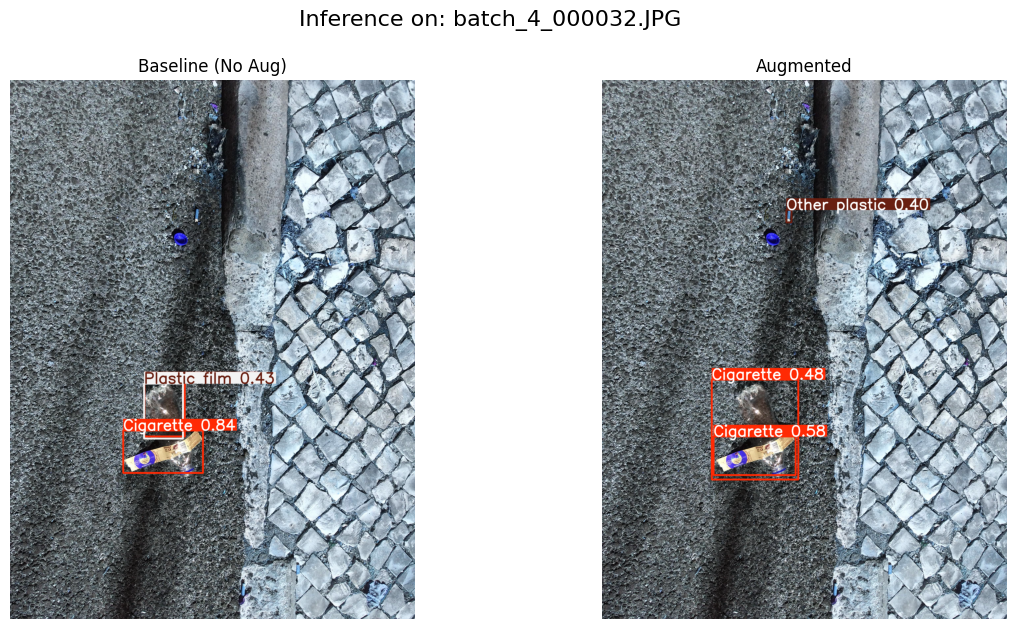

In [22]:
import os
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import display
from PIL import Image

# -----------------------
# Load models
# -----------------------
baseline_path = os.path.join(RESULTS_DIR, "baseline_pretrained_v1", "weights", "best.pt")
aug_path      = os.path.join(RESULTS_DIR, "augmented_v12", "weights", "best.pt")

model_baseline = YOLO(baseline_path)
model_aug      = YOLO(aug_path)

# -----------------------
# Select random test images
# -----------------------
test_img_dir = os.path.join(YOLO_BASE, "test", "images")
test_images = os.listdir(test_img_dir)
sample_imgs = random.sample(test_images, 3)  # pick 3 random images

# -----------------------
# Visualize predictions
# -----------------------
for img_name in sample_imgs:
    img_path = os.path.join(test_img_dir, img_name)

    # Baseline prediction
    results_base = model_baseline.predict(img_path, save=False, conf=0.25, show=False)
    base_img = results_base[0].plot()  # annotated image

    # Augmented prediction
    results_aug = model_aug.predict(img_path, save=False, conf=0.25, show=False)
    aug_img = results_aug[0].plot()

    # Display side by side
    fig, axes = plt.subplots(1, 2, figsize=(14,7))

    axes[0].imshow(base_img)
    axes[0].set_title("Baseline (No Aug)")
    axes[0].axis('off')

    axes[1].imshow(aug_img)
    axes[1].set_title("Augmented")
    axes[1].axis('off')

    plt.suptitle(f"Inference on: {img_name}", fontsize=16)
    plt.show()


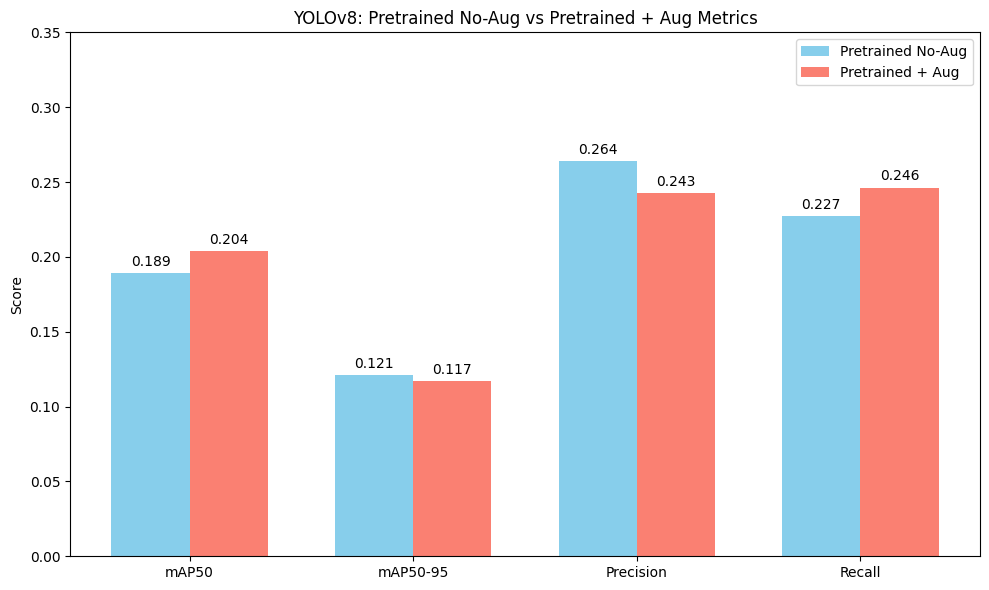

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['mAP50', 'mAP50-95', 'Precision', 'Recall']
no_aug_values = [0.189189, 0.121123, 0.264056, 0.227040]
aug_values    = [0.203650, 0.117061, 0.242872, 0.246281]

x = np.arange(len(metrics))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, no_aug_values, width, label='Pretrained No-Aug', color='skyblue')
rects2 = ax.bar(x + width/2, aug_values, width, label='Pretrained + Aug', color='salmon')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('YOLOv8: Pretrained No-Aug vs Pretrained + Aug Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 0.35)
ax.legend()

# Add value labels on bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


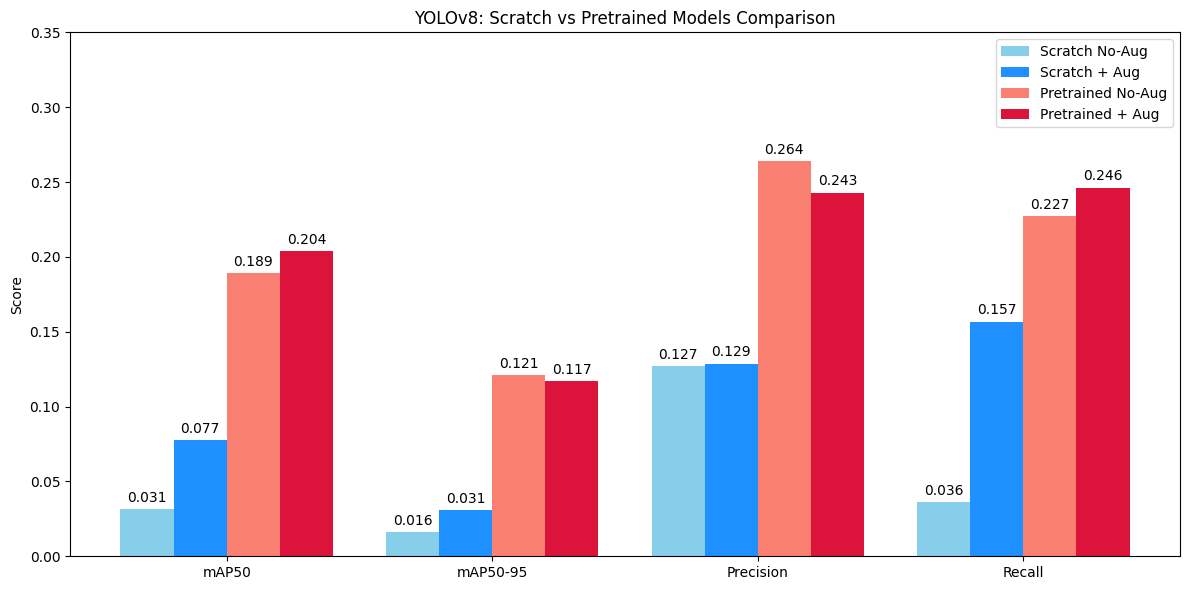

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['mAP50', 'mAP50-95', 'Precision', 'Recall']

# Values for each model
scratch_no_aug = [0.0313, 0.0159, 0.1272, 0.0361]
scratch_aug    = [0.0774, 0.0311, 0.1287, 0.1568]
pretrained_no_aug = [0.1892, 0.1211, 0.2641, 0.2270]
pretrained_aug    = [0.2037, 0.1171, 0.2429, 0.2463]

x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - 1.5*width, scratch_no_aug, width, label='Scratch No-Aug', color='skyblue')
rects2 = ax.bar(x - 0.5*width, scratch_aug, width, label='Scratch + Aug', color='dodgerblue')
rects3 = ax.bar(x + 0.5*width, pretrained_no_aug, width, label='Pretrained No-Aug', color='salmon')
rects4 = ax.bar(x + 1.5*width, pretrained_aug, width, label='Pretrained + Aug', color='crimson')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('YOLOv8: Scratch vs Pretrained Models Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 0.35)
ax.legend()

# Add value labels
for rects in [rects1, rects2, rects3, rects4]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()
